In [117]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, gamma, kstest


In [88]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [89]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

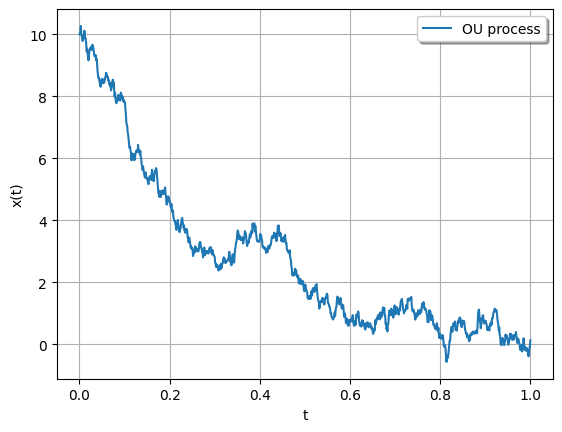

In [90]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

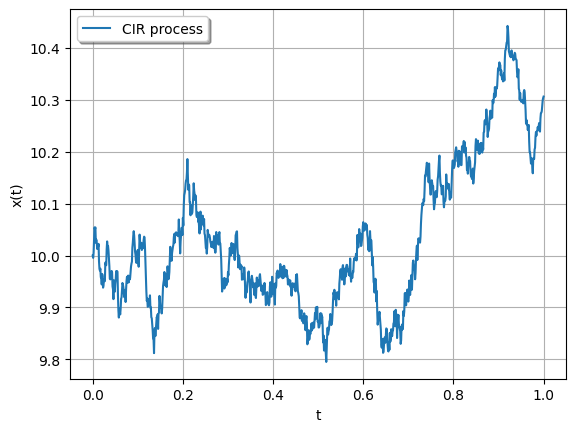

In [91]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

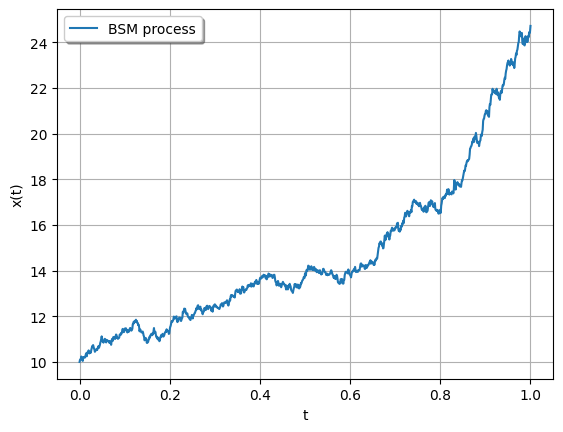

In [92]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [93]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


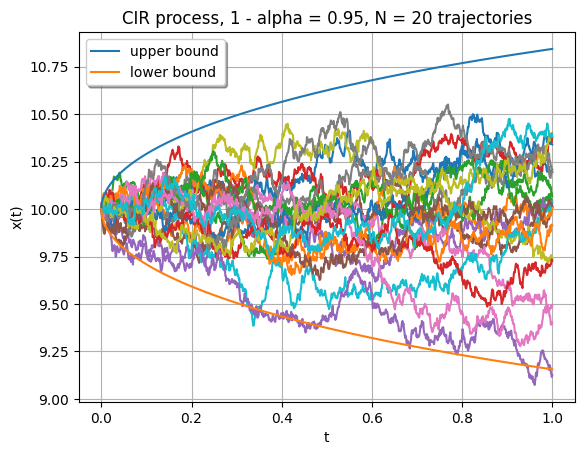

In [94]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


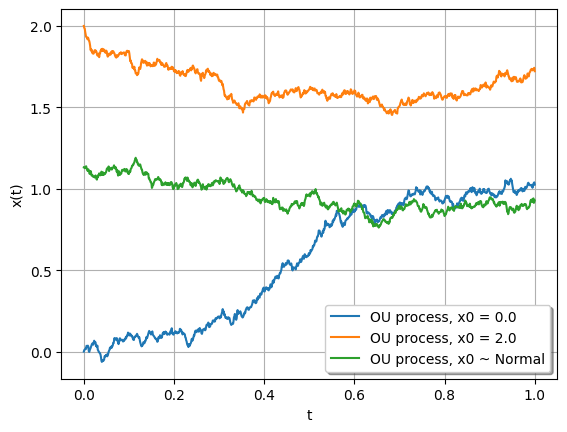

In [95]:
T = 1
Nx = 1
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Define a path with the stationary distribution from the graph and prove mathematically.

# Доказательство стационарного распределения процесса CIR

## Уравнение процесса CIR

Процесс CIR описывается следующим стохастическим дифференциальным уравнением (СДУ):

$$ dX_t = (\theta_1 - \theta_2 X_t) dt + \theta_3 \sqrt{X_t} dW_t $$

где:
- $(\theta_1)$ — параметр, отвечающий за среднее возврата,
- $(\theta_2)$ — скорость возврата к среднему,
- $(\theta_3)$ — волатильность,
- $(W_t)$ — винеровский процесс.

## Уравнение Фоккера-Планка

Уравнение Фоккера-Планка для процесса CIR описывает эволюцию плотности вероятности $(p(x,t))$:

$$
\frac{\partial p(x,t)}{\partial t} = - \frac{\partial}{\partial x} \left[ b(x) p(x,t) \right] + \frac{1}{2} \frac{\partial^2}{\partial x^2} \left[ \sigma^2(x) p(x,t) \right]
$$

где:
- $b(x)$ — функция дрейфа процесса,
- $(\sigma(x))$ — функция волатильности процесса.

Для процесса CIR:
- $(b(x) = \theta_1 - \theta_2 x)$,
- $(\sigma(x) = \theta_3 \sqrt{x})$.

Подставим $(b(x))$ и $(\sigma(x))$ в уравнение Фоккера-Планка:

$$
\frac{\partial p(x,t)}{\partial t} = - \frac{\partial}{\partial x} \left[ (\theta_1 - \theta_2 x) p(x,t) \right] + \frac{1}{2} \frac{\partial^2}{\partial x^2} \left[ \theta_3^2 x p(x,t) \right]
$$

## Уравнение для стационарного состояния

В стационарном состоянии плотность вероятности $(p(x,t))$ больше не зависит от времени, т.е.:

$$
\frac{\partial p(x,t)}{\partial t} = 0
$$

Уравнение Фоккера-Планка в стационарном состоянии превращается в:

$$
0 = - \frac{d}{dx} \left[ (\theta_1 - \theta_2 x) p(x) \right] + \frac{\theta_3^2}{2} \frac{d^2}{dx^2} \left[ x p(x) \right]
$$

## Развёрнутое уравнение



1. Первая часть:
$$
\frac{d}{dx} \left[ (\theta_1 - \theta_2 x) p(x) \right] = (\theta_1 - \theta_2 x) \frac{dp(x)}{dx} - \theta_2 p(x)
$$

2. Вторая часть:
$$
\frac{d^2}{dx^2} \left[ x p(x) \right] = \frac{d}{dx} \left[ p(x) + x \frac{dp(x)}{dx} \right] = 2 \frac{dp(x)}{dx} + x \frac{d^2 p(x)}{dx^2}
$$

Теперь подставим обе части в уравнение:

$$
0 = - \left[ (\theta_1 - \theta_2 x) \frac{dp(x)}{dx} - \theta_2 p(x) \right] + \frac{\theta_3^2}{2} \left[ 2 \frac{dp(x)}{dx} + x \frac{d^2 p(x)}{dx^2} \right]
$$

## Приведение уравнения к упрощённой форме

Теперь объединим термины и упростим уравнение:

$$
0 = - (\theta_1 - \theta_2 x) \frac{dp(x)}{dx} + \theta_2 p(x) + \frac{\theta_3^2}{2} \left[ 2 \frac{dp(x)}{dx} + x \frac{d^2 p(x)}{dx^2} \right]
$$

Это уравнение можно решить для стационарной плотности $(p(x))$.

## Решение уравнения

Решение этого уравнения даёт стационарное распределение процесса CIR, которое является **гамма-распределением** с параметрами:

$$
p(x) = C \cdot x^{\frac{2 \theta_1}{\theta_3^2} - 1} \cdot \exp\left( -\frac{2 \theta_2}{\theta_3^2} x \right)
$$

где \(C\) — это нормировочная константа, которая может быть найдена из условия нормировки, что интеграл плотности вероятности равен 1:

$$
C = \frac{\left( \frac{2 \theta_2}{\theta_3^2} \right)^{\frac{2 \theta_1}{\theta_3^2}}}{\Gamma\left( \frac{2 \theta_1}{\theta_3^2} \right)}
$$


Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts
around $1/2$, generate a path and plot it in graph. Prove your solution.


Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

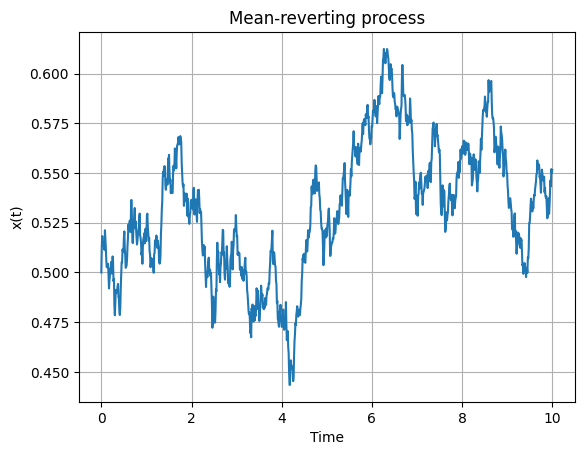

In [96]:
theta = 1.0  
sigma = 0.2
x0 = 0.5     
T = 10.0      
N = 1000
dt = T / N   
t = np.linspace(0, T, N)


def DesingProcess(theta, sigma, x0, T, N):
    dt = T / N
    x = np.zeros(N)
    x[0] = x0
    for i in range(1, N):
        dW = np.sqrt(dt) * np.random.normal()
        drift = theta * (0.5 - x[i-1])
        diffusion = sigma * x[i-1] * (1 - x[i-1])
        x[i] = x[i-1] + drift * dt + diffusion * dW
        
        
        if x[i] < 0:
            x[i] = 0
        elif x[i] > 1:
            x[i] = 1
    return x


path = DesingProcess(theta, sigma, x0, T, N)


plt.plot(t, path)
plt.title('Mean-reverting process')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid(True)
plt.show()

Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.





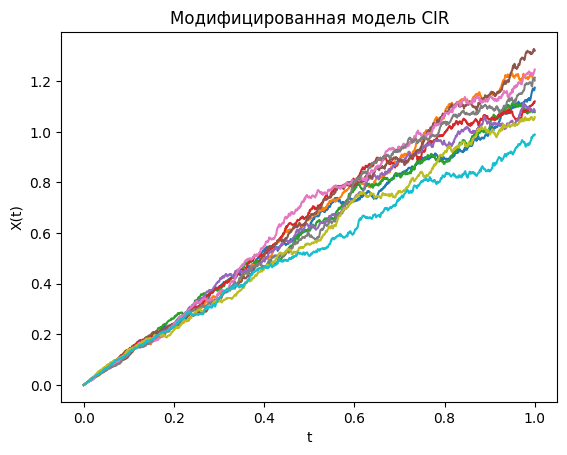

In [97]:
class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3, shift]
        self.bxt = lambda x: self.params[0] - self.params[1] * x + self.params[3]  
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))


x0 = 0
theta1 = 1.00
theta2 = 0.2
theta3 = 0.15
shift = 0.3
init_state =  x0 * np.ones(Nx)
params = [theta1, theta2, theta3 ,shift ]  
T = 1
Nx = 10
Nt = 1000


process = ModifiedCIRProcess(params, T, Nx, Nt)
t_data, x_data = process.EulerSolution()


plt.plot(t_data, x_data)
plt.title('Модифицированная модель CIR')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.show()

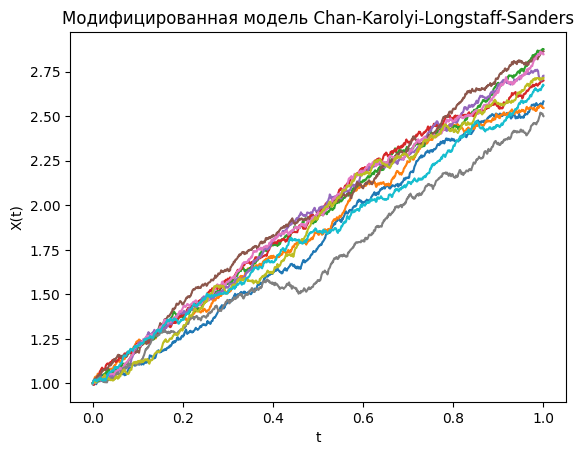

In [103]:
class CKLSProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3, gamma]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.power(np.maximum(x, 0), self.params[3]) 


theta1 = 2
theta2 = 0.2
theta3 = 0.15
gamma = 0.2
params = [theta1, theta2, theta3, gamma]
init_state = np.ones(Nx) * 1.0
process = CKLSProcess(params, T, Nx, Nt, init_state=init_state)
t_data, x_data = process.EulerSolution()


plt.plot(t_data, x_data)
plt.title('Модифицированная модель Chan-Karolyi-Longstaff-Sanders')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.show()

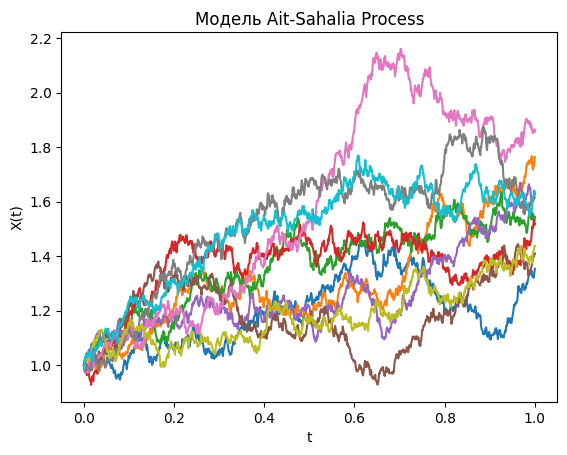

In [102]:
class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [a, b, c, d, e]
        self.bxt = lambda x: self.params[0] - self.params[1] * np.power(x, 2) + self.params[2] * np.power(np.maximum(x, 1e-4), -1) 
        self.sigmaxt = lambda x: self.params[3] * np.power(np.maximum(x, 1e-4), self.params[4])

a = 1
b = 0.2
c = 0.07
d = 0.3
e = 0.5
params = [a, b, c, d, e]

init_state = np.ones(Nx) * 1.0

process = AitSahaliaProcess(params, T, Nx, Nt, init_state=init_state)
t_data, x_data = process.EulerSolution()

plt.plot(t_data, x_data)
plt.title('Модель Ait-Sahalia Process')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.show()

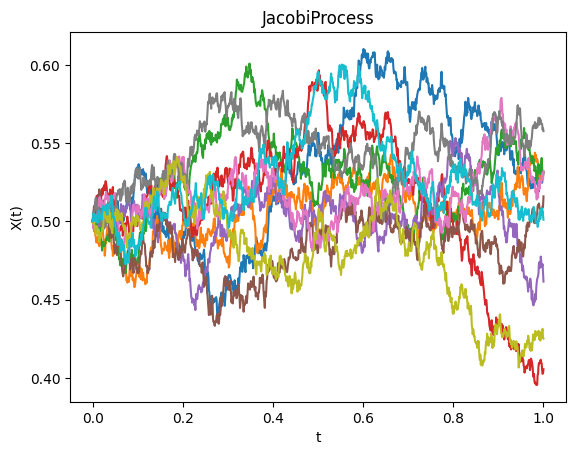

In [100]:
class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [kappa, theta, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(x * (1 - x))

kappa = 2
theta = 0.5
sigma = 0.2
params = [kappa, theta, sigma]

init_state = np.full(Nx, 0.5)
process = JacobiProcess(params, T, Nx, Nt, init_state=init_state)

t_data, x_data = process.EulerSolution()

plt.plot(t_data, x_data)
plt.title('JacobiProcess')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.show()




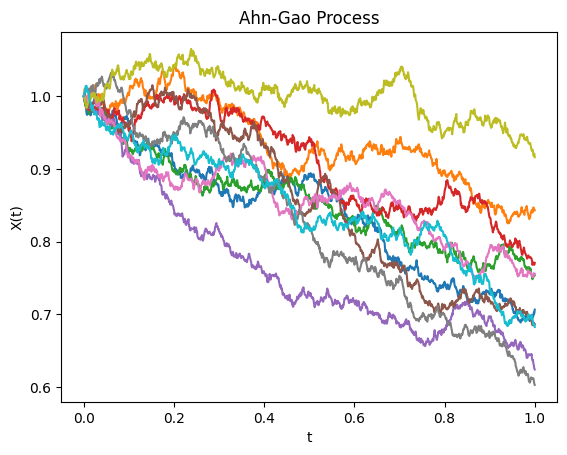

In [101]:
class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [a, b, sigma]
        
        self.bxt = lambda x: self.params[0] * np.log(np.maximum(x, 1e-4)) - self.params[1] * np.maximum(x, 1e-4)
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 1e-4))


a = 0.5  
b = 0.2  
sigma = 0.1  
params = [a, b, sigma]


init_state = np.ones(Nx) * 1.0  


process = AhnGaoProcess(params, T, Nx, Nt, init_state=init_state)


t_data, x_data = process.EulerSolution()


plt.plot(t_data, x_data)
plt.title('Ahn-Gao Process')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.show()


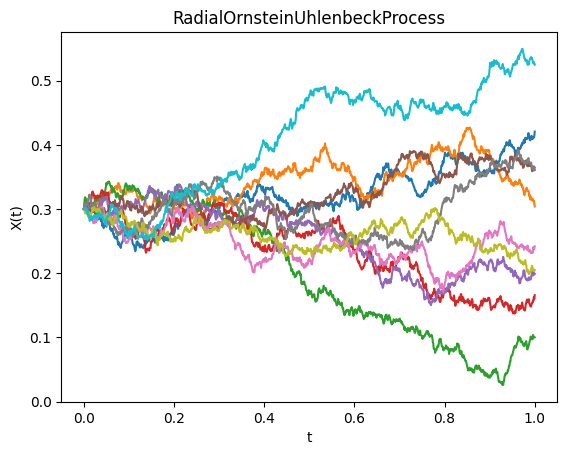

In [71]:
class RadialOrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params =[theta, mu, sigma] 
        self.bxt = lambda x: self.params[0] * (self.params[1] - np.abs(x))
        self.sigmaxt = lambda x: self.params[2]

mu = 0.3
params = [theta, mu, sigma]
init_state = np.abs(params[1]) * np.ones(Nx)
process = RadialOrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state=init_state)


t_data, x_data = process.EulerSolution()


plt.plot(t_data, x_data)
plt.title('RadialOrnsteinUhlenbeckProcess')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.show()



Task 6.

Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

In [106]:
class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)
    
    
    def A_t(self, t):
        
        return np.exp(-self.params[1] * t) * self.init_state[0] + self.params[0] * (1 - np.exp(-self.params[1] * t))

    def B_t(self, t):
        
        return self.params[2] * np.exp(-self.params[1] * t)

    def moment(self, t, n):
        kappa = self.params[1]
        A_t_val = self.A_t(t)
        B_t_val = self.B_t(t)
        moment_sum = 0
        
        for j in range(int(n // 2) + 1):
            term = A_t_val**(n - 2 * j) * B_t_val**(2 * j) * ((1 / (2 * kappa)) * (np.exp(2 * kappa * t) - 1))**(2 * j)
            moment_sum += term
        
        return moment_sum


kappa = 1.0
theta = 0.45
sigma = 1.0
params = [theta, kappa, sigma]


T = 1
Nx = 1
Nt = 1000


X0 = 1.0
init_state = np.ones(Nx) * X0


process = CoxIngersollRossProcess(params, T, Nx, Nt, init_state=init_state)


t = 1.0  
first_moment = process.moment(t, 1)
second_moment = process.moment(t, 2)

print(f"Первый момент E[X(t)] = {first_moment}")
print(f"Второй момент E[X^2(t)] = {second_moment}")

Первый момент E[X(t)] = 0.6523336926442933
Второй момент E[X^2(t)] = 1.8066370921007553


Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by
$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.

